# Brain tumor 3D segmentation with MONAI

## Setup environment

## Setup imports

In [ ]:
import os
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
# from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

## Setup data directory

In [ ]:
set_determinism(seed=0)
root_dir = '../DecathlonDataset'
batch_size = 4

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[240, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [ ]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir="../DecathlonDataset",
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DecathlonDataset(
    root_dir="../DecathlonDataset",
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## Check data shape and visualize

In [ ]:
#pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()


In [ ]:
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [ ]:
class Unet_3D(torch.nn.Module):
    def __init__(self):
        super(Unet_3D, self).__init__()
        
        self.input_layer = torch.nn.Conv3d(in_channels=4, out_channels=8, kernel_size=(3,3,3), padding=(1,1,1))
        
        self.encoder_layer_1_1 = torch.nn.Conv3d(in_channels=8,  out_channels=8, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_1_1 = torch.nn.BatchNorm3d(8)
        self.encoder_layer_1_2 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_1_2 = torch.nn.BatchNorm3d(8)
        self.encoder_layer_1_3 = torch.nn.Conv3d(in_channels=8, out_channels= 16, kernel_size=(3,3,3), padding=(1,1,1))
        self.maxpool_1 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_2_1 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_2_1 = torch.nn.BatchNorm3d(16)
        self.encoder_layer_2_2 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_2_2 = torch.nn.BatchNorm3d(16)
        self.encoder_layer_2_3 = torch.nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.maxpool_2 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_3_1 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_3_1 = torch.nn.BatchNorm3d(32)
        self.encoder_layer_3_2 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_3_2 = torch.nn.BatchNorm3d(32)
        self.encoder_layer_3_3 = torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.maxpool_3 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_4_1 = torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_4_1 = torch.nn.BatchNorm3d(128)
        self.encoder_layer_4_2 = torch.nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_4_2 = torch.nn.BatchNorm3d(128)

        self.upsample_3 = torch.nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_3_1 = torch.nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_3_1 = torch.nn.BatchNorm3d(64)
        self.decoder_layer_3_2 = torch.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_3_2 = torch.nn.BatchNorm3d(64)
        self.decoder_layer_3_3 = torch.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)

        self.upsample_2 = torch.nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_2_1 = torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_2_1 = torch.nn.BatchNorm3d(32)
        self.decoder_layer_2_2 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_2_2 = torch.nn.BatchNorm3d(32)
        self.decoder_layer_2_3 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        
        self.upsample_1 = torch.nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_1_1 = torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_1_1 = torch.nn.BatchNorm3d(16)
        self.decoder_layer_1_2 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_1_2 = torch.nn.BatchNorm3d(16)
        self.decoder_layer_1_3 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)

        self.output_layer = torch.nn.Conv3d(in_channels=16, out_channels=3, kernel_size=(1,1,1), bias=False)
 
    def forward(self, x):

        x = self.input_layer(x)

        x = self.encoder_layer_1_1(x)
        x = self.encoder_batch_norm_1_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_batch_norm_1_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_1_3(x))
        layer_1_head = x
        # print("1 ",x.shape)
        x = self.maxpool_1(x)

        x = self.encoder_layer_2_1(x)
        x = self.encoder_batch_norm_2_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_2_2(x)
        x = self.encoder_batch_norm_2_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_2_3(x))
        layer_2_head = x
        # print("2 ",x.shape)
        x = self.maxpool_2(x)

        x = self.encoder_layer_3_1(x)
        x = self.encoder_batch_norm_3_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_3_2(x)
        x = self.encoder_batch_norm_3_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_3_3(x))
        layer_3_head = x
        # print("3 ",x.shape)
        x = self.maxpool_3(x)

        x = self.encoder_layer_4_1(x)
        x = self.encoder_batch_norm_4_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_4_2(x)
        x = self.encoder_batch_norm_4_2(x)
        x = torch.nn.functional.relu(x)

        x = self.upsample_3(x)
        layer_3_tail = x
        x = torch.concat((layer_3_head, layer_3_tail), dim =1)
        # print("con3 ",x.shape)
        x = self.decoder_layer_3_1(x)
        x = self.decoder_batch_norm_3_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_3_2(x)
        x = self.decoder_batch_norm_3_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_3_3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.upsample_2(x)
        layer_2_tail = x
        x = torch.concat((layer_2_head, layer_2_tail), dim=1)
        # print("con2 ",x.shape)
        x = self.decoder_layer_2_1(x)
        x = self.decoder_batch_norm_2_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_2_2(x)
        x = self.decoder_batch_norm_2_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_2_3(x)
        x = torch.nn.functional.relu(x)

        x = self.upsample_1(x)
        layer_1_tail = x
        x = torch.concat((layer_1_head, layer_1_tail), dim=1)
        # print("con1 ",x.shape)
        x = self.decoder_layer_1_1(x)
        x = self.decoder_batch_norm_1_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_1_2(x)
        x = self.decoder_batch_norm_1_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_1_3(x)
        x = torch.nn.functional.relu(x)

        output = self.output_layer(x)

        return output

In [ ]:
max_epochs = 100
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

model = Unet_3D()
model.to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

## Execute a typical PyTorch training process

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("=" * 30)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0.0
    batch_loss = 0.0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        
        print('\r',
            f"{step}/{len(train_loader)}"
            f", train_loss: {loss.item():.4f}",
            end=' '
        )
    lr_scheduler.step()
    epoch_loss = epoch_loss/(step+1e-8)
    epoch_loss_values.append(epoch_loss)
    print('\n')
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "junsuk_best_segmentation_unet_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

In [ ]:
import numpy
numpy.save("../temp/unet_epoch_loss_values.npy", epoch_loss_values)
numpy.save("../temp/unet_metric_values.npy", metric_values)
numpy.save("../temp/unet_metric_values_tc.npy", metric_values_tc)
numpy.save("../temp/unet_metric_values_wc.npy", metric_values_wt)
numpy.save("../temp/unet_metric_values_et.npy", metric_values_et)

## Plot the loss and metric

In [ ]:
import numpy
import torch
import matplotlib.pyplot as plt

epoch_loss_values = numpy.load("../temp/unet_epoch_loss_values.npy")
metric_values = numpy.load("../temp/unet_metric_values.npy")
metric_values_tc = numpy.load("../temp/unet_metric_values_tc.npy")
metric_values_wc = numpy.load("../temp/unet_metric_values_wc.npy")
metric_values_et = numpy.load("../temp/unet_metric_values_et.npy")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values

plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
# plt.subplot(1, 3, 2)
# plt.title("Val Mean Dice WT")
# x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
# y = metric_values_wt
# plt.xlabel("epoch")
# plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

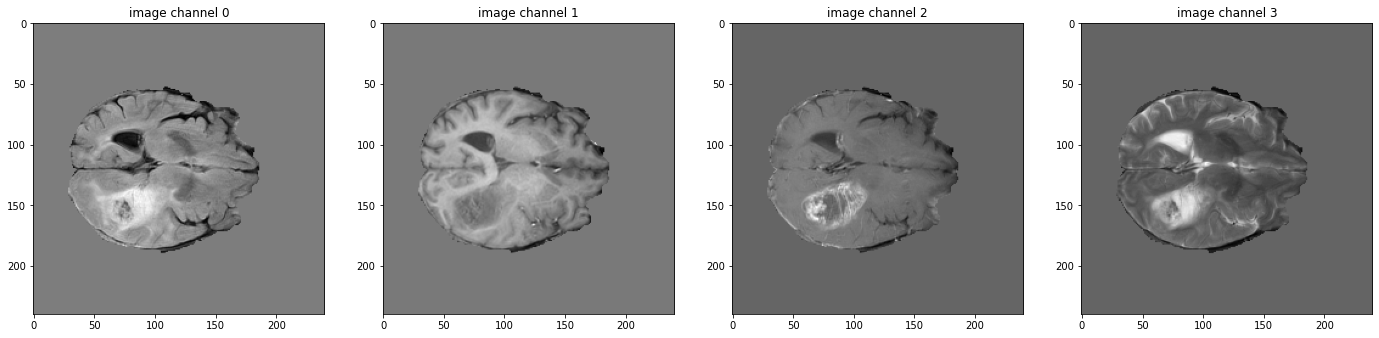

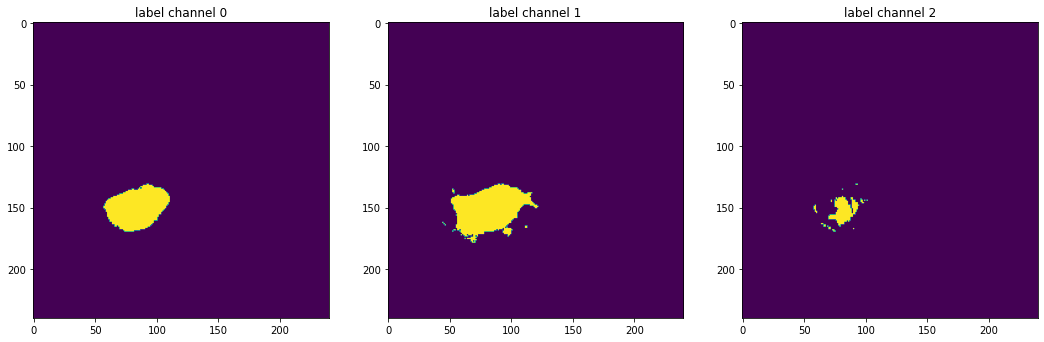

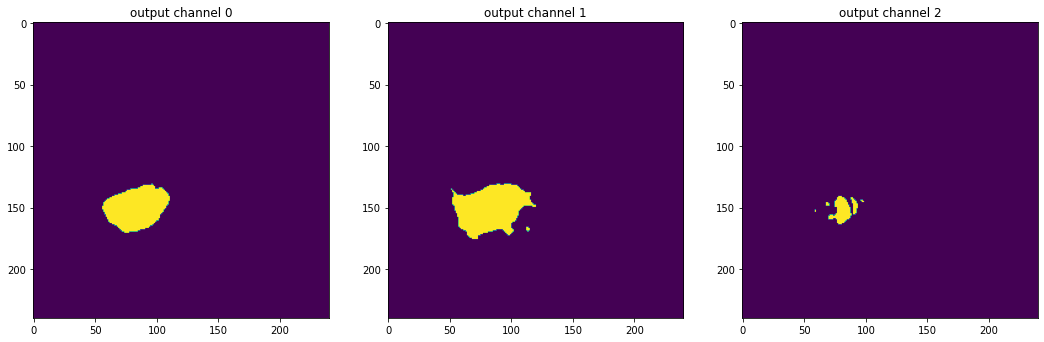

In [42]:
model=Unet_3D()
model.load_state_dict(torch.load(os.path.join("../temp/best_metric_model.pth")))
model.to(device)
# model.to(device)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

## Evaluation on original image spacings

In [51]:
val_ds = DecathlonDataset(
    root_dir="../DecathlonDataset",
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [52]:
root_dir = '../temp'
model = Unet_3D()
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = inference(val_inputs)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric = dice_metric.aggregate().item()
    metric_values.append(metric)
    metric_batch = dice_metric_batch.aggregate()
    metric_tc = metric_batch[0].item()
    metric_values_tc.append(metric_tc)
    metric_wt = metric_batch[1].item()
    metric_values_wt.append(metric_wt)
    metric_et = metric_batch[2].item()
    metric_values_et.append(metric_et)
    dice_metric.reset()
    dice_metric_batch.reset()

print("Metric on original image spacing: ", metric)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

Metric on original image spacing:  0.7526335716247559
metric_tc: 0.8027
metric_wt: 0.8939
metric_et: 0.5613
